In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/risk_certificate')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
import scipy.stats as stats 
from certificate.run_simulations import get_results_matching_parameters, aggregate_data
import seaborn as sns

In [9]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [10]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [11]:
colors_by_method = {}
baseline_methods = ['prior','successive_elimination','ucb','dominant','omniscient','sample_split','fixed_k']
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(baseline_methods)))

for i,m in enumerate(baseline_methods):
    colors_by_method[m] = vidris[i]

## AISTATS Plots

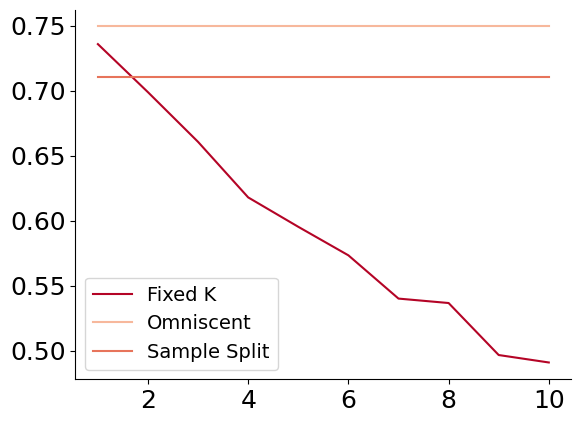

In [45]:
dataset = "vary_n_m"
temp_params = {'number_arms': 10, 'sample_size': 500, 'first_stage_size': 250}#, 'max_pulls_per_arm': 50}#, 'first_stage_pulls_per_arm': 25}
results = get_results_matching_parameters(dataset,"",temp_params)
results = aggregate_data(results)

value_by_k = [results['k_{}'.format(i)][0] for i in range(1,temp_params['number_arms']+1)]
plt.plot(list(range(1,temp_params['number_arms']+1)),value_by_k,label='Fixed K',color=colors_by_method['fixed_k'])
plt.plot(list(range(1,temp_params['number_arms']+1)),[results['omniscient'][0] for i in range(0,temp_params['number_arms'])],label='Omniscent',color=colors_by_method['omniscient'])
plt.plot(list(range(1,temp_params['number_arms']+1)),[results['sample_split'][0] for i in range(0,temp_params['number_arms'])],label='Sample Split',color=colors_by_method['sample_split'])
plt.legend()



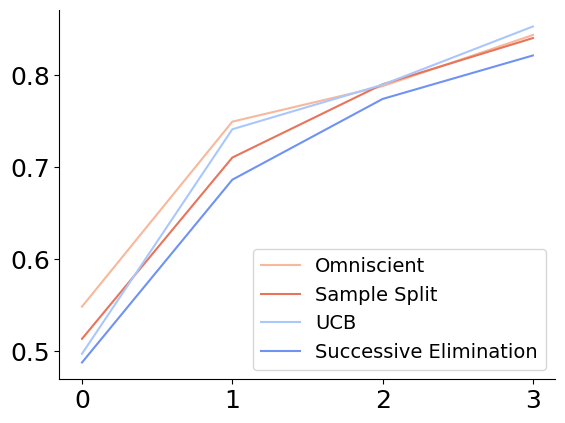

In [53]:
dataset = "vary_n_m"
sample_sizes = [100,500,1000,5000]
methods = ['omniscient','sample_split','ucb','successive_elimination']
nice_names = ['Omniscient','Sample Split','UCB','Successive Elimination']
temp_params = {'number_arms': 10}

for i in range(len(methods)):
    method_name = methods[i]
    nice_name = nice_names[i] 
    data = []

    for s in sample_sizes:
        temp_params['sample_size'] = s
        if s == 100:
            s = 80
        temp_params['first_stage_size'] = s//2

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = aggregate_data(results)
        data.append(results[method_name][0])
    plt.plot(list(range(len(sample_sizes))),data,label=nice_name,color=colors_by_method[method_name])

plt.legend()



Text(0.5, 13.52222222222222, 'Fraction initial stage')

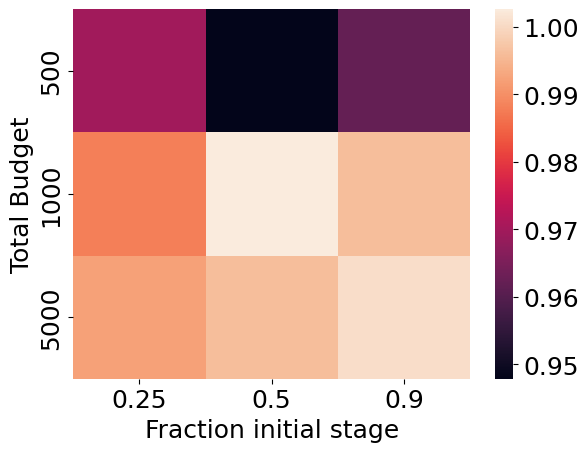

In [22]:
dataset = "vary_n_m"
sample_sizes = [500,1000,5000]
first_stage_sizes = [0.25,0.5,0.9]
temp_params = {'number_arms': 10}

total_array = np.zeros((len(sample_sizes),len(first_stage_sizes)))

for i in range(len(sample_sizes)):
    for j in range(len(first_stage_sizes)):
        temp_params['sample_size'] = sample_sizes[i]
        temp_params['first_stage_size'] = int(first_stage_sizes[j]*sample_sizes[i])
        
        if temp_params['first_stage_size'] == 125:
            temp_params['first_stage_size'] = 100

        if temp_params['first_stage_size'] == 1250:
            temp_params['first_stage_size'] = 1000

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = aggregate_data(results)
        
        total_array[i,j] = results['sample_split'][0]/results['omniscient'][0]

sns.heatmap(total_array)
plt.xticks([0.5,1.5,2.5],labels=first_stage_sizes)  # Set the tick labels
plt.yticks([0.5,1.5,2.5],labels=sample_sizes)
plt.ylabel("Total Budget")
plt.xlabel("Fraction initial stage")


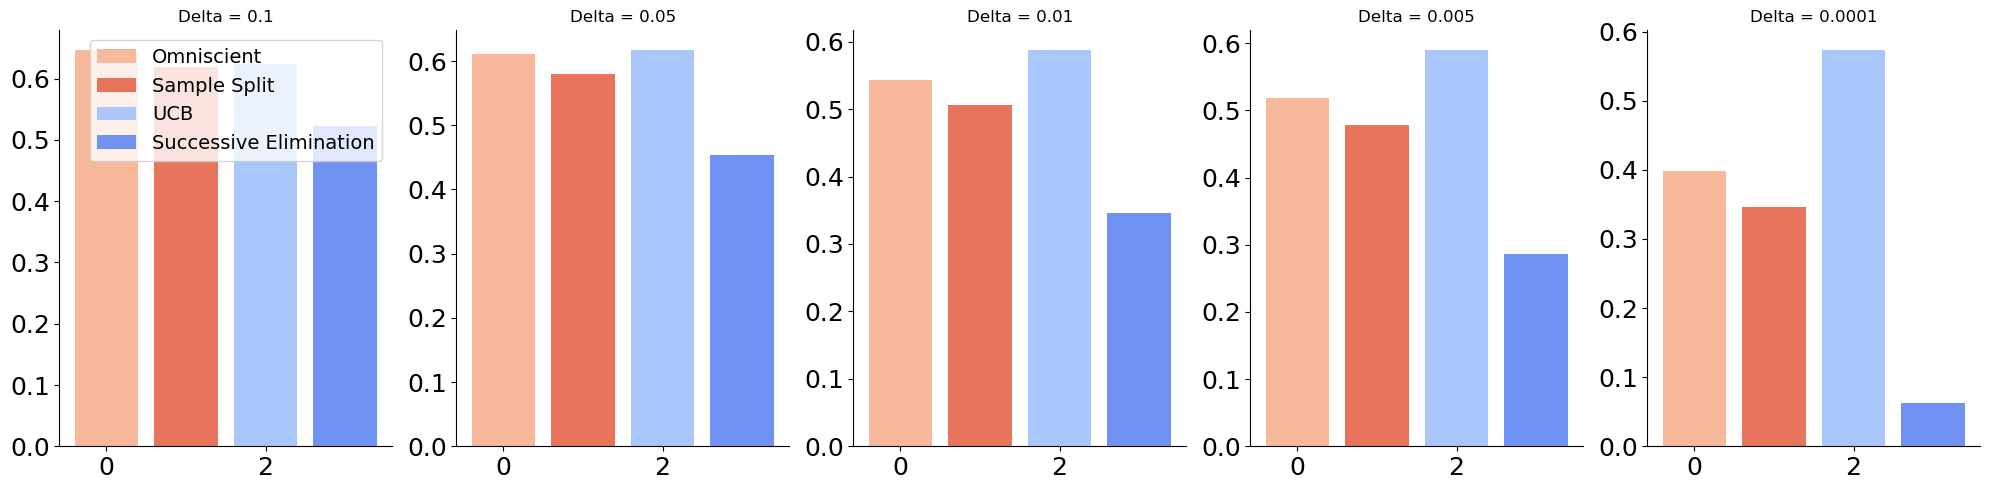

In [33]:
dataset = "vary_delta"
delta_values = [0.1,0.05,0.01,0.005,0.0001]
methods = ['omniscient','sample_split','ucb','successive_elimination']
nice_names = ['Omniscient','Sample Split','UCB','Successive Elimination']
temp_params = {'number_arms': 10, 'sample_size': 200, 'first_stage_size': 100}
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Adjust figsize as needed

for idx,delta in enumerate(delta_values):
    temp_params['delta'] = delta
    results = get_results_matching_parameters(dataset,"",temp_params)
    results = aggregate_data(results)
    values = [results[m][0] for m in methods]  # Extract the values for each method

    # Create a bar plot on the corresponding subplot
    axes[idx].bar(list(range(len(methods))), values, color=[colors_by_method[i] for i in methods],label=nice_names)
    axes[idx].set_title(f'Delta = {delta}')

axes[0].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()



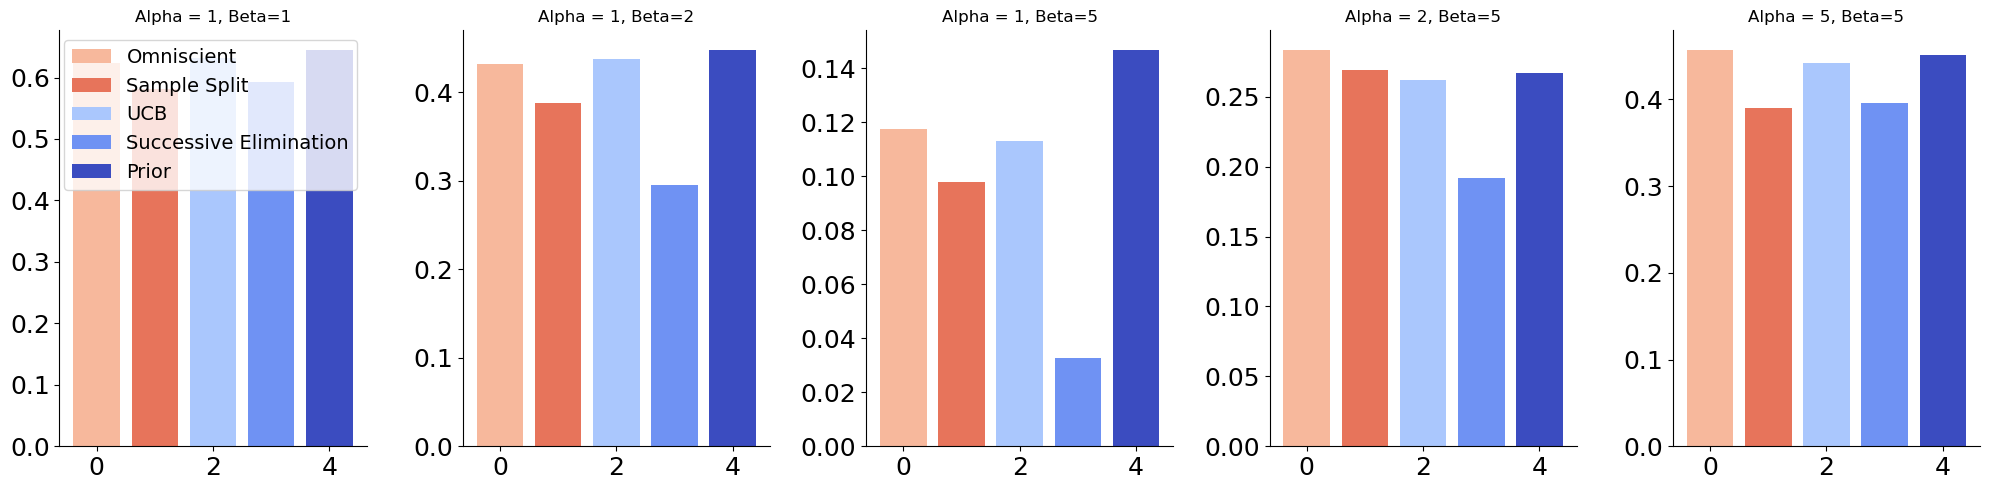

In [44]:
dataset = "prior_data"
alpha_beta_values = [(1,1),(1,2),(1,5),(2,5),(5,5)]
methods = ['omniscient','sample_split','ucb','successive_elimination','prior']
nice_names = ['Omniscient','Sample Split','UCB','Successive Elimination',"Prior"]
temp_params = {'number_arms': 10, 'sample_size': 200, 'first_stage_size': 100}
fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Adjust figsize as needed

for idx,(alpha,beta) in enumerate(alpha_beta_values):
    temp_params['reward_parameters'] = {"alpha": float(alpha), "beta": float(beta), "diff_mean_1": 2, "diff_mean_2": 2, "diff_std_1": 2, "diff_std_2": 2}
    results = get_results_matching_parameters(dataset,"",temp_params)
    results = aggregate_data(results)
    values = [results[m][0] for m in methods]  # Extract the values for each method

    # Create a bar plot on the corresponding subplot
    axes[idx].bar(list(range(len(methods))), values, color=[colors_by_method[i] for i in methods],label=nice_names)
    axes[idx].set_title(f'Alpha = {alpha}, Beta={beta}')

axes[0].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()



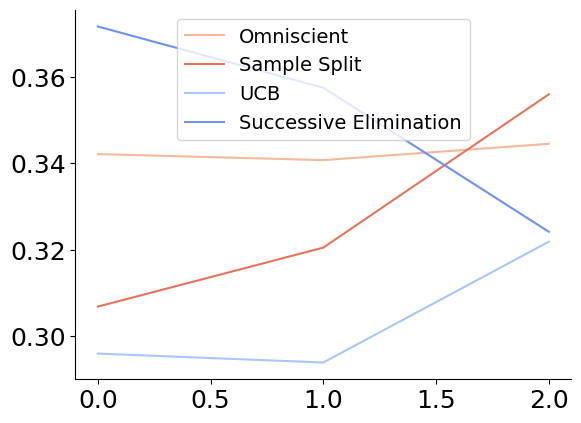

In [53]:
dataset = "vary_gaps"
mu_1 = [0.01,0.02,0.05]
methods = ['omniscient','sample_split','ucb','successive_elimination']
nice_names = ['Omniscient','Sample Split','UCB','Successive Elimination']
temp_params = {'number_arms': 10,'sample_size': 500}

for i in range(len(methods)):
    method_name = methods[i]
    nice_name = nice_names[i] 
    data = []
    
    for s in mu_1:
        temp_params['diff_mean_1'] = s
        results = get_results_matching_parameters(dataset,"",temp_params)
        results = aggregate_data(results)
        data.append(results[method_name][0])
    plt.plot(list(range(len(sample_sizes))),data,label=nice_name,color=colors_by_method[method_name])

plt.legend()



In [57]:
dataset = "vary_gaps"
mu_1 = [0.01,0.02,0.05,0.1]
methods = ['omniscient','sample_split','ucb','successive_elimination']
nice_names = ['Omniscient','Sample Split','UCB','Successive Elimination']
temp_params = {'number_arms': 10,'sample_size': 500, 'diff_mean_2': 0.005}

for i in range(len(methods)):
    method_name = methods[i]
    nice_name = nice_names[i] 
    data = []
    
    for s in mu_1:
        temp_params['diff_mean_1'] = s
        results = get_results_matching_parameters(dataset,"",temp_params)
        print(s,len(results))
        results = aggregate_data(results)
        data.append(results[method_name][0])
    plt.plot(list(range(len(sample_sizes))),data,label=nice_name,color=colors_by_method[method_name])

plt.legend()



0.01 0


KeyError: 'omniscient'